# Final Project: Machine Learning - Jordan Marks

## Import and Configure Required Libraries
Import libraries. We will use Pandas to pre-process and clean the data, Seaborn to visualize the data and perform exploratory analysis, scipy for statistical analysis, and scikit learn (a Python ML library) to train a model that predicts the sex of a person.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import export_graphviz

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn import metrics

from scipy import stats

%matplotlib inline

In [2]:
sns.set_style("whitegrid")

Custom functions:

In [3]:
# Discritizes columns. Note it changes the order of columns.
def digitize(x, bins=[], cols=[]):
    mask = np.ones(x.shape[1], np.bool)
    mask[cols] = 0
    
    return np.hstack((np.apply_along_axis(np.digitize, 1, x[:,cols], bins=bins), x[:,mask]))

## Dataset: Stress for Students

This is the development dataset. It doesn't have all the features (for the sake of time), but please feel free to add you own or recommended changes! The list of the features it does have is here. See the codebook for how to interpret everything. It is all organized by the day that it is reported. Survey results might be a little funny because they were collected before and after the stress, so there might be some data manipulation required for those. 

user, DATE, STRESS_LEVEL, STRESS_NOMINAL, sleep_hours, sleep_rating, social_sleep, exercise_have, exercise_time, exercise_schedule, exercise_walk, social_number, alone_working, alone_relaxing, other_working, other_relaxing, dining_hall_breakfast, dining_hall_lunch, dining_hall_dinner, mood_happy_or_not, mood_happy, mood_sad_or_not, mood_sad, mood_tomorrow, mood_now, class_number, deadline, piazza_days online, piazza_views, piazza_contributions, piazza_questions, piazza_notes, piazza_answers, gpa_all, gpa_13s, cs_65, BigFive_Talkative, BigFive_FindsFault, BigFive_Thorough, BigFive_Depressed, BigFive_Original, BigFive_Reserved, BigFive_Helpful, BigFive_Careless, BigFive_Relaxed, BigFive_Curious, BigFive_Energetic, BigFive_Quarrels, BigFive_Reliable, BigFive_Tense, BigFive_DeepThinker, BigFive_Enthusiasm, BigFive_Forgiving, BigFive_Disorganized, BigFive_Worries, BigFive_Imagination, BigFive_Quiet, BigFive_Trusting, BigFive_Lazy, BigFive_EmotionallyStable, BigFive_Inventive, BigFive_Assertive, BigFive_Aloof, BigFive_Perseveres, BigFive_Moody, BigFive_Artistic, BigFive_Shy, BigFive_Considerate, BigFive_Efficient, BigFive_Calm, BigFive_Routine, BigFive_Outgoing, BigFive_Rude, BigFive_Plans, BigFive_Nervous, BigFive_Reflective, BigFive_noArtist, BigFive_Cooperate, BigFive_Distracted, BigFive_Sophisticated, Loneliness_InTune, Loneliness_Companionship, Loneliness_NoOne, Loneliness_NotAlone, Loneliness_Friends, Loneliness_InCommon, Loneliness_NotClose, Loneliness_Interests, Loneliness_Outgoing, Loneliness_close, Loneliness_LeftOut, Loneliness_Superficial, Loneliness_notWell, Loneliness_Isolated, Loneliness_Companionship, Loneliness_understand, Loneliness_Withdrawn, Loneliness_Around, Loneliness_Talk, Loneliness_TurnTo

## Exploratory Analysis and Feature Selection
Everybody: for Monday, please plot the features versus the STRESS_NOMINAL value to determine what you think is a reasonable tarting place for a model. We'll discuss on Monday.

We begin by loading the development set from the data directory. Note that the file is compressed, comma separated values file. We load it into a Pandas dataframe:

In [4]:
dev = pd.read_csv('../Final Project/data/dev_data_2.csv')

Considering stress level categorical for now.

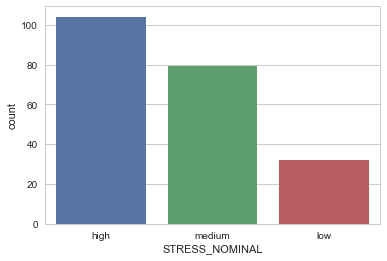

In [5]:
sns.countplot(x="STRESS_NOMINAL", data=dev)

Lots more students are reporting medium to high stress than low stress. That suggests to me that there is a bit of a problem!

I'll look at exercise first, because I imagine there is some correlation. exercise_have = 1 means somebody did exercise, when exercise_have = 2 means they did not exercise.

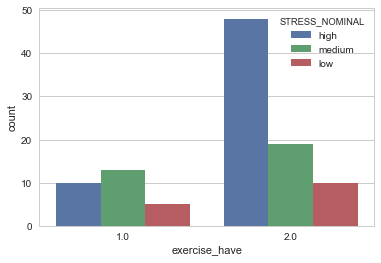

In [6]:
sns.countplot(data=dev, x='exercise_have', hue='STRESS_NOMINAL')

Then looking at how long somebody exercises...

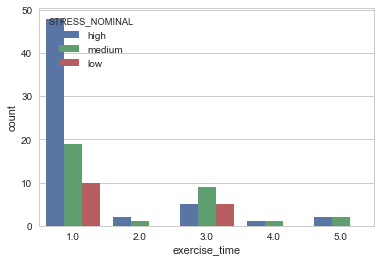

In [7]:
sns.countplot(data=dev, x='exercise_time', hue='STRESS_NOMINAL')

What if we look at it the other way?

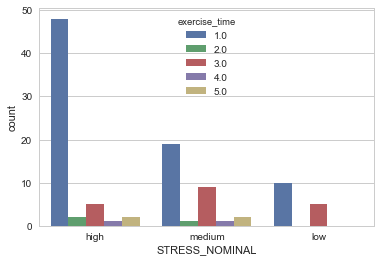

In [8]:
sns.countplot(data=dev, x='STRESS_NOMINAL', hue='exercise_time')

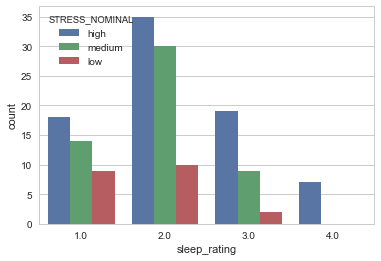

In [9]:
sns.countplot(data=dev, x='sleep_rating', hue='STRESS_NOMINAL')

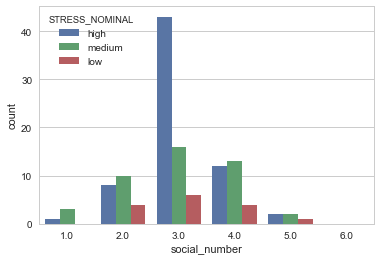

In [10]:
sns.countplot(data=dev, x='social_number', hue='STRESS_NOMINAL')

# STOP HERE. AFTER THIS, IT IS JUST A COPY OF BYTE 4.

### Feature Engineering and Selection
Next, we look for features that might be predictive of the two sexes. Often real world datasets are not clean and require a good understanding of the data before we can apply a machine learning algorithm. Also, data often contains features that are in a format that is not predictive of the class. In such cases training an algorithm on the features without any changes of modification will produce bismal results and the automated feature selection algorithms will not work (if you are in the intermediate to expert stream, we invite you to try to do something like that on this dataset and see what happens).

That is why in this byte we approach this the classification as a feature engineering problem. Here we will explore the data set first and use our intuition, assumptions, and existing knowledge to select a few features that will hopefully help us in the prediction task.

We start off by looking at personal income.

#### Personal Income (PINCP)
We begin by exploring the personal income feature. We hypothesize that females will have lower income than males because of wage inequality (https://en.wikipedia.org/wiki/Gender_pay_gap_in_the_United_States).

Dataset documentation tells us that the feature contains NaN values, but that those values mean that the person is 15 years or younger. That means that the child had no income (the parent or guardian would get the income in this case). That is fine in our case because we only conisder adults, ages 18 and up.

We still impute any possible missing values by replacing them with an income of 0.

In [114]:
dev.loc[dev['PINCP'].isnull(),'PINCP'] = 0
dev.loc[dev['WAGP'].isnull(),'WAGP'] = 0

We then compare the distribution of personal income across the two classes:

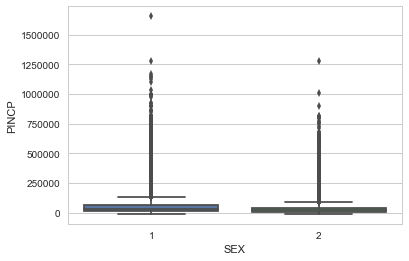

In [115]:
sns.boxplot(data=dev, x='SEX', y='PINCP')

And the distribution of wage income across the two classes.

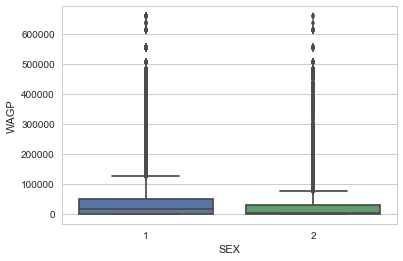

In [116]:
sns.boxplot(data=dev, x='SEX', y='WAGP')

The boxplots shows that there is likely a difference in personal income and wages between the two classes (despite large number of ourliers). We also note that the data is likely not normally distributed, which will come into play later. However, there also does not seem to be a clear (linear) separation between the two classes.

We pause our exploration of personal income to take a look at other features.

#### Age
We look at age because we noted that we will have difficulty classifying children ages 15 and below, so we should probably consider age in our model somehow.

We note and confirm that there should be no missing values, and plot our data again:

In [117]:
len(dev[dev['AGEP'].isnull()])

0

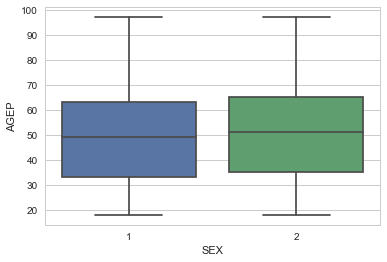

In [118]:
sns.boxplot(data=dev, x='SEX', y='AGEP')

Eyeballing the data, we do not see any major differences between the two sexes. Also, note that although there are differences in the life expectency between the two sexes (https://en.wikipedia.org/wiki/List_of_countries_by_life_expectancy), the data reffers to the person's current age, and not their projected life expectancy. We choose not to include age as it is right now.

#### Marital Status
The age discussion above brings up an interesting point: females have higher life expectancy. Thus, we would expect that there would be more widowed females than males. Thus, we search the dataset for a feature that indicates if a person is widowed or not: marital satatus.

However, unlike the previous two features, this feature is categorical although in the data set it is encoded as a number. <strong>You always have to ensure that features have the right type!</strong>

Because it is categorical, we use count plot to look at it:

In [119]:
len(dev[dev['MAR'].isnull()])

0

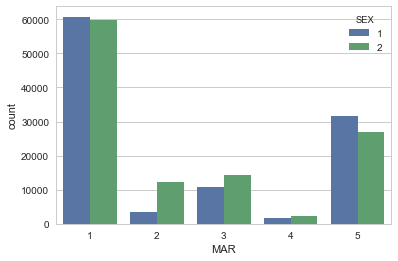

In [120]:
sns.countplot(data=dev, x='MAR', hue='SEX')

Eyeballing the data, it looks like we are correct. However, this feature will only help in a small number of cases when a person is widowed. What else can you see in this chart?

#### Occupation
Gender differences in occupational distribution among workers persist even if occupation is a volountary choice (https://www.bls.gov/opub/mlr/2007/06/art2full.pdf). Thus, we explore each person's occupation as a potential feature.

However, not only is this feature categorical, documentation reveals that there is also a large number of possible values for this feature. This often significantly degrades machine learning algorithm performance because there is usually not enough examples for each value to make accurate inference. 

Since the first two digits of the occupation code represent an occupation class, we can reduce the number of values by grouping everything with the same starting digits together. 

We preserve the old feature for reference, and add a new one. We first convert all values that are not null:

In [121]:
dev['SCOP_REDUCED'] = pd.to_numeric(dev[dev['SOCP'].notnull()]['SOCP'].str.slice(start=0, stop=2))

And then we preserve the special value of NaN in this case (less than 16 years old or never worked) and assign it to a special code '00':

In [122]:
dev.loc[dev['SCOP_REDUCED'].isnull(), 'SCOP_REDUCED'] = 0

We now look at the difference in occupation across sexes.

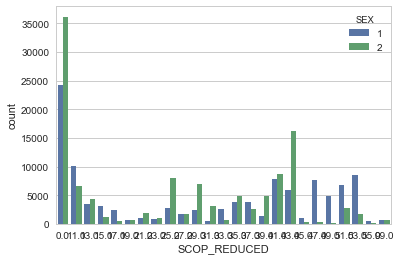

In [123]:
sns.countplot(data=dev, x='SCOP_REDUCED', hue='SEX')

We see that there are still differences between occupation categories between the two sexes (e.g., construction '47' is still dominated by males, but education and administrative is dominated by females).

#### Revisiting Wage Gap
Now we are ready to look at the wage gap again. Our goal is to capture the wage gap (if it exists). We consider three different ways to do this:

1. We could look at the income proportion of the person compared to the total family income.
2. We can compare how far the person's income is from the median or mean salary of males and females.
3. We can compare how far the person's income is from the median or mean salary of males and females in their occupation.

The following barplot shows personal income by occupation and gender, using comparative boxplots (option 3). Can you make a plot for option 1 (gender vs family income) or option 2 (gender vs personal income)? Can you plot the same things for wage instead of income? Ask yourself which of these plots is most informative and why?

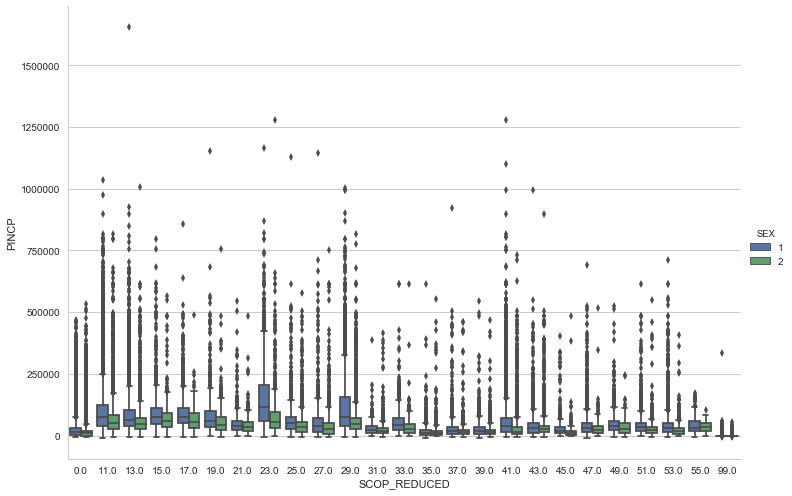

In [124]:
sns.factorplot(data=dev[['SCOP_REDUCED', 'SEX', 'PINCP']], x='SCOP_REDUCED', y='PINCP', hue='SEX', kind='box', size=7, aspect=1.5)


#### Jordan's Exploration: Individual and Family Incomes
Per the directed questions above, I was interested in looking at individual incomes compared the the family incomes. I first performed a gut check to see if reported family incomes were very different for males and females. Based on the marriage breakdown, I would expect that family incomes are similar for both sexes because the majority of individuals are married.

In [125]:
dev.loc[dev['FINCP'].isnull(),'FINCP'] = 0

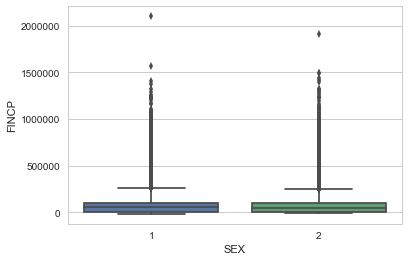

In [126]:
sns.boxplot(data=dev, x='SEX', y='FINCP')

#### Jordan's Exploration: Individual and Family Incomes
As expected, the family income looks pretty similar for males and females. I looked at a scatter plot comparing the family income to an individual's income to determine where there are differences. In this visualization, I was trying to determine whether any groups would emerge. Since the distributions of family incomes look similar, are individuals of a certain sex contributing to this in a particular way?

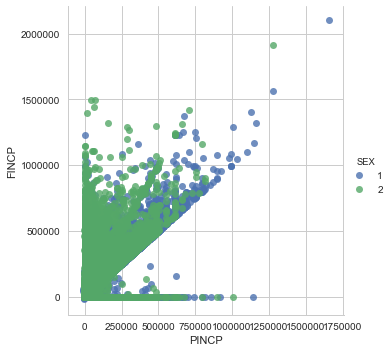

In [127]:
sns.lmplot('PINCP', 'FINCP', data=dev, fit_reg=False, hue='SEX')

#### Jordan's Exploration: Individual and Family Incomes
By comparing individual income to family income, we can see that women (in green) have a slightly lower individual income compared to the family income, but there is a lot of overlap between the family and individual income. Looking at low personal income but high family income, the majority of the points correspond to females. For high personal and high family income, the points are primarily males. This suggests that there may be some income gap between the different sexes contributing to the family income - males tend to be driving the income higher. That said, there is a large overlap between individual income and family income, so this is perhaps not the most informative comparison.

#### Wage Comparison
As directed, I next looked at wage differences for the different sexes both with respect to different occupations and family income.

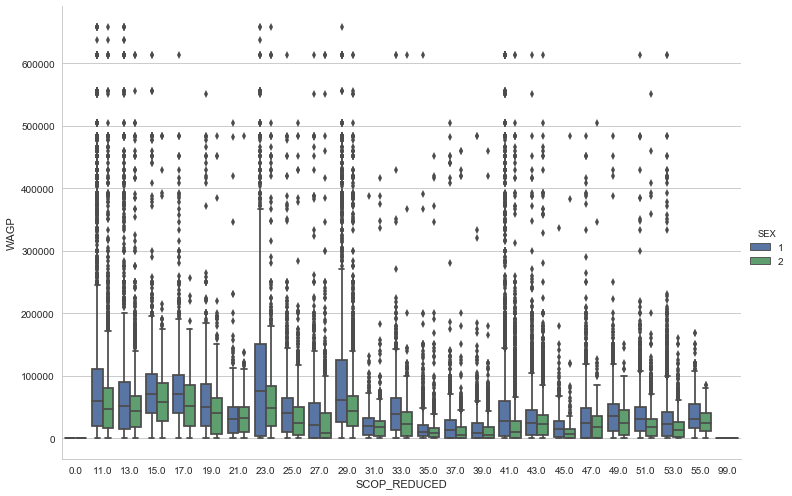

In [129]:
sns.factorplot(data=dev[['SCOP_REDUCED', 'SEX', 'WAGP']], x='SCOP_REDUCED', y='WAGP', hue='SEX', kind='box', size=7, aspect=1.5)


#### Wage Comparison
The wage comparison across the different occupations looks similar to the the income bar chart. Looking at a few illustrative examples, lawyers (23) and doctors (29)show a much larger standard deviation for males than for females with respect to wage. This doesn't seem to add much differentiating power compared to the income comparison.

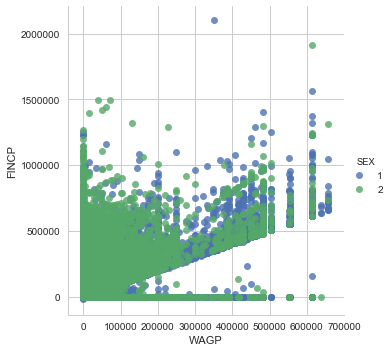

In [130]:
sns.lmplot('WAGP', 'FINCP', data=dev, fit_reg=False, hue='SEX')

#### Wage Comparison
By looking at wages compared to the family income, we do see a bit of a difference as compared to the individual income graph shown earlier. Across the individual wages, it seems that females have a lower reported family income than males do. We can also see a line of mostly female datapoints at the 0 income point, suggesting that these individuals are not earning money, but their spouse is. 

#### Income/Wage Gap Summary

<strong>So given these discussions, which features should we include?</strong>
The family income seems to be a useful feature because it points out the extreme cases: where one spouse is not earning income but the family income is still high. This seems to be largely females. I will try to include this feature in hopes that the algorithm will be able to pick out the low individual income and high family income discrepancy.

The discussion of wage in different occupations is a useful feature as it shows that some occupations ar emore prone to income gaps than others. It also shows that some fields are more likely to have one sex or another.

The individual wage and income both seem to show some differences, and can be useful when considered in conjunction with the above two features.

#### Jordan's Exploration
<em>Educational Attainment, Another look at Age, Military Service, and Weight</em>

The first additional feature I considered was educational attainment. Related to the career exploration above, gender equity in education has historically been a problem (https://www2.ed.gov/about/offices/list/ocr/docs/gender-equity-in-education.pdf). Older generations might show more males achieving high levels of education, whereas a continued focus in recent years on equity has shifted that to a greater percentage of women receiving higher degrees. Intuitively, I would also thing that women would need higher levels of education to be competitive in the workforce, so I think some of these social changes might be reflected in the levels of educational attainment.

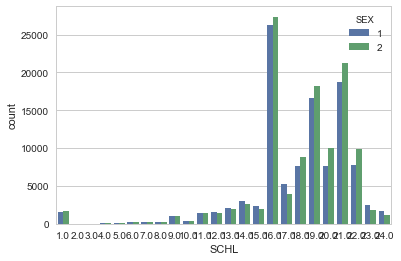

In [131]:
len(dev[dev['SCHL'].isnull()])
sns.countplot(data=dev, x='SCHL', hue='SEX')

On first pass, a lot of these values aren't useful. I wouldn't expect a different in school aged children - since schooling is a requirement, so categories 1 through 15 should be grouped together so that higher ed differences are more noticeable. I created a new variable to bin this data accordingly.

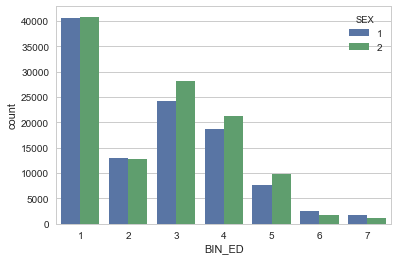

In [132]:
bins = [0, 16, 18, 20, 21, 22, 23, 24]
group_names = ['1', '2', '3', '4', '5', '6', '7']
dev['BIN_ED'] = pd.cut(dev[dev['SCHL'].notnull()]['SCHL'],bins, labels=group_names)
sns.countplot(data=dev, x='BIN_ED', hue='SEX')

As anticipated, the counts in K-12 schooling are nearly equivalent for males and females. We do see that there are more women than men getting associates, bachelors, and masters degrees, but there are more men than women receiving PhD's and doing postdoctoral research. The PhD level and beyond may show a slight difference, but it is impacting such as small subset of the data that it won't make a big difference.

The associates through masters level does impact a good percentage of the population, so this, or the raw educational feature might be useful.

<em>Education and Income</em>

In general, one would expect a higher education to lead to a greater income. But is this true for both sexes?

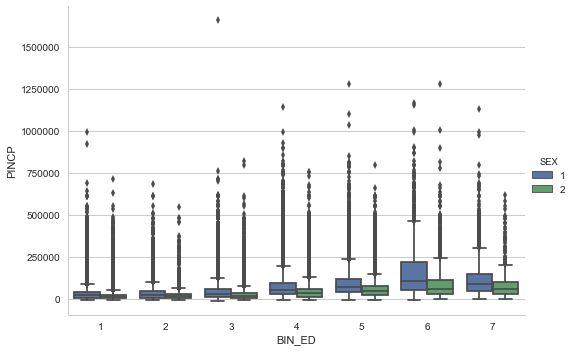

In [147]:
sns.factorplot(data=dev[['BIN_ED', 'SEX', 'PINCP']], x='BIN_ED', y='PINCP', hue='SEX', kind='box', size=5, aspect=1.5)

This gets us an interesting result: at all levels of educational attainment, males have a higher average income than females. This becomes particularly noticeable at the higher levels of education, but it is important to keep in mind that this is a very small percentage of the population.

#### A second look at Age
In the provided analysis, there was a discussion that there is a slight age difference in men and women as women tend to live longer. I attempted to visualize this difference by binning these data; if I provide bins, I was hoping the algorithm might be able to better detect cut-offs that are useful for differentiating the sexes.

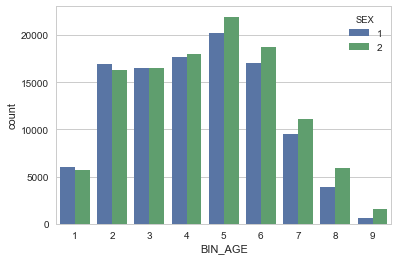

In [148]:
bins2 = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
group_names2 = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
dev['BIN_AGE'] = pd.cut(dev[dev['AGEP'].notnull()]['AGEP'],bins2, labels=group_names2)
sns.countplot(data=dev, x='BIN_AGE', hue='SEX')

At ages above 50, we do start to see a bigger difference between the sexes in terms of number of people of each sex. This might be a useful feature, as it helps the algorithm break down the ages into the ones where the differences are more noticeable. The one downside to this feature is that the bins that show a bigger difference impact a smaller amount of the population. For example, although the 90 - 100 year olds show many more females than males, this is such a small percentage of the population that it may not make a noticeable difference.

#### Military Service
A second feature I considered was military service. There have been historical differences in enlisting in the military, such as drafts in earlier wars, and in whether women can serve in combat roles (https://journalistsresource.org/studies/society/gender-society/women-military-research-roundup). These differences would make me think that this feature would be very predictive: I anticipate many more females have never served in the military than men.

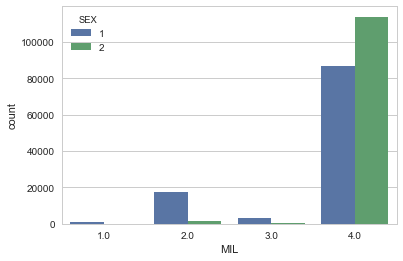

In [149]:
len(dev[dev['MIL'].isnull()])
sns.countplot(data=dev, x='MIL', hue='SEX')

As anticipated, there is a noticeable difference between the distribution of both the categories "on active duty in the past, but not now" and "never served in the military." While there do seem to be some visual differences betweeen the other categories, these influence only a small percentage of the population. However, it does seem that there are stark differences between the sexes in the military roles.

<em>Military and Age</em>

In an attempt to better understand the presence of the different sexes in the military, I was wondering if there were particularly obvious age differences that influenced the data. Because of policies like the draft, as well as social practices like joining the military right after high school, I wondered if there would be any large differences between the sexes in these different categories.

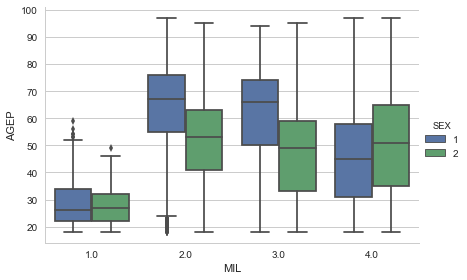

In [150]:
sns.factorplot(data=dev[['MIL', 'SEX', 'AGEP']], x='MIL', y='AGEP', hue='SEX', kind='box', size=4, aspect=1.5)

The age differences do not seem as informative as the count of peope involved. It seems that within each of these categories, the ages look similar for each sex. I'll leave this feature. 

#### Weight
Because the survey collected some physical information about the individual, I was hoping to use that to my advantage. I know that there are differences in average height of males and females, so I was hoping that I could use the reported weight to detect a difference as well.

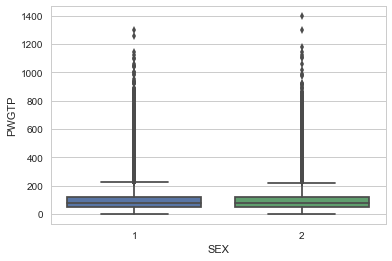

In [151]:
len(dev[dev['PWGTP'].isnull()])
sns.boxplot(data=dev, x='SEX', y='PWGTP')

The differences in weight are not as obvious as I would expect, but perhaps this is due to the very young or very old respondents, when the differences are less likely to be obvious. I looked at weight with respect to age. 

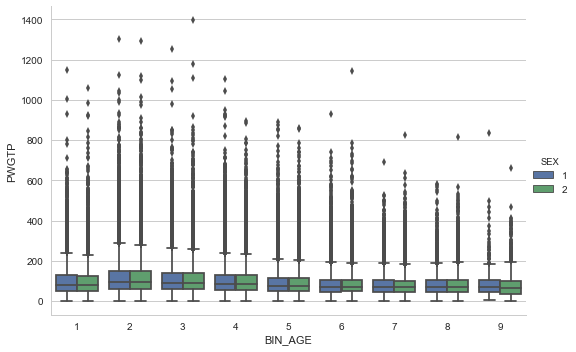

In [152]:
sns.factorplot(data=dev[['PWGTP', 'SEX', 'BIN_AGE']], x='BIN_AGE', y='PWGTP', hue='SEX', kind='box', size=5, aspect=1.5)

Even controlling for the different age groups, we see that there is not a large difference in the median weights between the difference genders. My assumption was proved false for this dataset, so I will not include this feature.

### Feature Summary
Here we finalize a list of features we created and/or selected in the previous step. Below is a list of features we will use. Remember to add your own features if you selected and/or created any.

In [143]:
# Modify this cell to add more features if any.
select_features = ['PINCP', 'WAGP', 'MAR', 'SCOP_REDUCED', 'MIL', 'SCHL', 'BIN_AGE']
categorical_features = ['MAR', 'SCOP_REDUCED', 'MIL', 'SCHL', 'BIN_AGE']

# Used for specifying which features to bin in $20,000 increments.
# Note that if you have features you would like to bin in a custom way, then you will have to modify the Naive Bayes
# classifier below.
monetary_features = ['PINCP', 'WAGP']

We will now create a new dev data frame containing only the selected features and the class.

In [144]:
select_dev = dev[select_features + ['SEX']]

### Questions you need to answer:
<em>Summarize your findings about different features you selected, including insights about why they should help you predict/classify males and females.</em>

I decided to include the following features

<em>Marital Status</em>: This feature is useful because of the category corresponding to the 'widowed' status - more females tend to be in this category because they tend to live longer.

<em>Military Service</em>: Fewer women than men serve in the military due to both political measures and social expectations. We see a strong difference in the involvement of these groups.

<em>Educational Attainment and Occupation</em>: We see some differences in the level of education and the different occupations that the sexes tend to get. These are particularly illustrative when considered in combination with the income.

<em>Personal Income, Wage, and Age</em>: While these do show some differences, they are most useful when considered in conjunction with some of the previously stated features. For example, looking at specific wage gaps within an occupation or for a different level of educational attainment might be useful to the classifier.

## Algorithm Selection and Optimization
In this section we will use the features we selected above to train and evaluate different machine leaning algorithms. Often it is not immediately clear which algorithm will perform the best on the dataset. Even if we are certain that an algorithm will do well, we need to compare it with a baseline algorithm (e.g., Zero R, which always selects the majority class) to make sure that we are improving on the status quo.

We will compare a few algorithms to find out which one is most promissing. We perform this selection on the development set so that we do not overfit on the training data (which would have effects on the performance of the algorithm on unseen data). Because our development set is comparably small, we will use cross-validation to evaluate our algorithms. However, because we also want to optimize the algorithms we are comparing (to ensure we are selecting the best configuration) we will use what we call inner-outer 10 fold cross validation.

In the inner fold we will optimize an algorithm and pick the best optimization, and in the outerfold we will compare the best opimized algorithms.

In most cases we desire an algorithm with a high accuracy as a score. This metric is a decent indicator of performance when classifying balanced classes (as is our case). However, sometimes it is even more important to consider the impact of errors on the performance (precision and recall) and the general quality of the fit (kappa statistic).

We begin by defining a set of algorithms that we will compare. We chose 3 algorithms:

1. Zero R, which always picks the majority class. This is our baseline.
2. Naive Bayes, which is a fast algorithm and is based on the Bayes' theorem, but with a naive assumptions about independence of features given the class (http://scikit-learn.org/stable/modules/naive_bayes.html)
3. Decision Tree, which is a non-parametric supervised learning method used for classification that predicts the value of a target variable by learning simple decision rules inferred from the data features (copied from http://scikit-learn.org/stable/modules/tree.html).

<strong>If you are in the intermediate/expert path you need to pick your own algorithm to add to the race!</strong> If you are unsure where to start, you can use this chart to help you pick an algorithm: http://scikit-learn.org/stable/tutorial/machine_learning_map/. Then add specifications for your algorithm below (use the existing examples on how to create your own pipeline for the algorithm):

In [145]:
classifiers = {}
classifier_parameters = {}

# Zero R
# This classifier does not require any additional preprocessing of data.
classifiers['ZeroR'] = DummyClassifier(strategy='prior')

# Binomial NB classifier
# This classifier requires that all features are in binary form.
# We can easily transform categorical data into binary form, but we have to first disretize continius variables first.
classifiers['Naive Bayes'] = Pipeline([
    ('discretize', FunctionTransformer(func=digitize, kw_args={'bins':np.array([0.0, 20000.0, 40000.0, 80000.0, 100000.0]), 'cols':pd.Series(select_features).isin(monetary_features)})), 
    ('tranform', OneHotEncoder(categorical_features='all')), 
    ('clf', BernoulliNB())])

# Decision Tree classifier
# This classifier can work on continious features and can find a good separation point on its own.
# We still have to convert categorical data to binary format.
classifiers['Decision Tree'] = Pipeline([('tranform', OneHotEncoder(categorical_features=pd.Series(select_features).isin(categorical_features))), ('clf', DecisionTreeClassifier())])

# Maximum Depth for a decision tree controls how many levels deep the tree will go before it stops.
# More levels means less generalizability, but fewer levels means less predictive power.
classifier_parameters['Decision Tree'] = {'clf__max_depth':(1, 3, 9, 12)}


We prepare out development set by creating 10 folds we will use to evaluate the algorithms.

We now iterate over the classifiers and report the metrics for all of them. Sklearn offers a number of functions to quickly score results of a cross validation, but we would like to make sure that all of the algorightms run on the same folds. So we quickly code our own experiment below. Note that this will take some time to run, so don't rush past it until it stops producing output.

In [146]:
# Create a label encoder to transform 1-MALE, 2-FEMALE into classes that sklearn can use (0 and 1).
le = LabelEncoder() 

# Split features and class into two dataframes.
X_dev = select_dev.ix[:, select_dev.columns != 'SEX'].values
y_dev = le.fit_transform(select_dev['SEX'].values)

# setup the 10 fold cross validation
kf = KFold(n_splits=10, shuffle=True)

# Initialize scores dict
scores = pd.DataFrame(columns=['fold', 'algorithm', 'parameters', 'accuracy', 'precision', 'recall'])

# For each fold run the classifier (outer CV).
fold = 0
for train_index, test_index in kf.split(X_dev):
    X_train, X_test = X_dev[train_index], X_dev[test_index]
    y_train, y_test = y_dev[train_index], y_dev[test_index]
    
    fold = fold + 1

    # Iterate over classifiers
    for name, clf in classifiers.items():
        # If the classifier has parameters, then run inner CV.
        # Luckily sklearn provides a quick method to do this.
        if name in classifier_parameters:
            gs = GridSearchCV(estimator=clf, param_grid=classifier_parameters[name])
            gs.fit(X_train, y_train)
            y_pred = gs.predict(X_test)
            best_params = str(gs.best_params_)
        else:
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            best_params = 'default'
        
        # collect the scores for printing out later
        scores = scores.append(pd.DataFrame(data={'fold':[fold],
                                                  'algorithm':[name], 
                                                  'parameters':[best_params], 
                                                  'accuracy':[accuracy_score(y_test, y_pred)], 
                                                  'precision':[precision_score(y_test, y_pred)],
                                                  'recall':[recall_score(y_test, y_pred)]}), 
                               ignore_index=True)
        

C:\Users\jcmarks\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
C:\Users\jcmarks\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
C:\Users\jcmarks\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
C:\Users\jcmarks\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
C:\Users\jcmarks\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
C:\Users\jcmarks\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
C:\Users\jcmarks\Anaconda3\lib\sit

### Selecting the Best Algorithm
Here we analyze the results of our experiment and compare the algorithm scores to find the best algorithm. The sumary and box plot below shows the accuracy of the best algorithms in the outer fold. See if you can also plot the precision and recall to better understand your results. Do you see anything unusual? Can you explain it?

In [153]:
scores[['algorithm', 'accuracy', 'precision', 'recall']].groupby(['algorithm']).median()

,accuracy,precision,recall
algorithm,,,
Decision Tree,0.732914,0.740294,0.742785
Naive Bayes,0.665232,0.672927,0.684290
ZeroR,0.516071,0.516071,1.000000


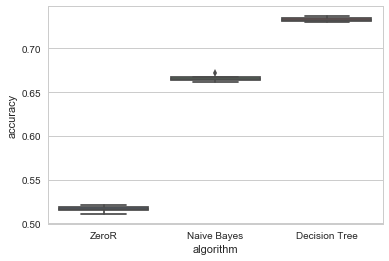

In [154]:
sns.boxplot(data=scores, x='algorithm', y='accuracy')

From the boxplots we can see that the Decision Tree was the best. That said, the accuracy of the decision tree is still pretty low at .71 (71%). 

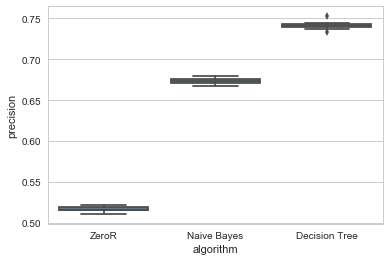

In [155]:
sns.boxplot(data=scores, x='algorithm', y='precision')

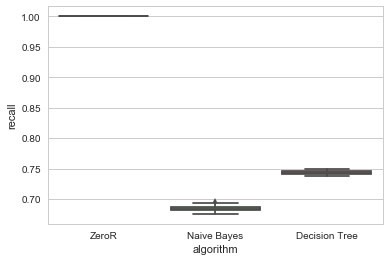

In [156]:
sns.boxplot(data=scores, x='algorithm', y='recall')

#### Jordan's Observations:

While the inclusion of these additional features improved the accuracy, it is more informative to see what they are getting better at. In particular, we see that the decision tree has both improved recall and precision when compared both to the baseline feature space and to the Naive Bayes algorithm. This means that is is improving both at reducing the number of false positives (females classified as males) and at false negatives (males classified as females).

This is a very good sign, as it tells me that the new features are even better at making the different groups look distinct.

#### Running Statistical Tests
We now run a statistical test on the accuracies across different algorithms to ensure that the results above did not happen by chance. We ensured that we trained and evalueted all of the algorithms on the same outer folds, which means that we need to run a pairwise comparison. Also, although eyeballing the boxplot above we could assume that the accuracies came from normal distribution, we know that accuracy is takes value on an interval from [0,1] so we choose a non-parametric test instead (Friedman test, https://en.wikipedia.org/wiki/Friedman_test). We will perform post-hoc pairwise comparison using a Wilcoxon test.

Our null-hypothesis is that there is no difference between the algorithms.

In [157]:
matrix = scores.pivot(index='fold', columns='algorithm', values='accuracy').as_matrix()
stats.friedmanchisquare(matrix[:,0], matrix[:,1], matrix[:,2])

FriedmanchisquareResult(statistic=20.0, pvalue=4.5399929762484861e-05)

In [158]:
for i in range(np.shape(matrix)[1]):
    for j in range(i+1, np.shape(matrix)[1]):
        print(stats.wilcoxon(matrix[:,i], matrix[:,j], correction=True))

WilcoxonResult(statistic=0.0, pvalue=0.0058892700418174768)
WilcoxonResult(statistic=0.0, pvalue=0.0059215370241487084)
WilcoxonResult(statistic=0.0, pvalue=0.0059215370241487084)


The results reject the null hypothesis (because the p values are small, <.005), meaning that we have some confidence there is a repeatable, real difference beteen the algorithms (even if the accuracy is low).

The Decision Tree classifier is unique in the sense that it is easy to visualize the decisions that it is making. Here we look at the top 3 levels of the best algorithm we trained on the whole development set (if you have graph viz installed on your machine):

In [159]:
features = select_dev.columns.tolist()
features = features[1:len(features)-1]

le = LabelEncoder() 

# Split features and class into two dataframes.
X_dev = select_dev.ix[:, select_dev.columns != 'SEX']
y_dev = le.fit_transform(select_dev['SEX'].values)

X_dev_long = pd.get_dummies(data=X_dev, columns=categorical_features)

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_dev_long, y_dev)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [160]:
import pydotplus
dot_data = export_graphviz(clf,
                           out_file=None,
                           feature_names=X_dev_long.columns,
                           class_names=['male', 'female'],  
                           filled=True, rounded=True,  
                           special_characters=True)  
# ran correctly for me when I first installed anaconda, but not now
# if you have trouble, just comment these two lines out and use the print line below instead.
#graph = pydotplus.graph_from_dot_data(dot_data)  
#Image(graph.create_png()) 

print(dot_data)

digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname=helvetica] ;
edge [fontname=helvetica] ;
0 [label=<MIL_4.0 &le; 0.5<br/>gini = 0.4994<br/>samples = 224156<br/>value = [108334, 115822]<br/>class = female>, fillcolor="#399de510"] ;
1 [label=<SCOP_REDUCED_43.0 &le; 0.5<br/>gini = 0.1515<br/>samples = 23415<br/>value = [21481, 1934]<br/>class = male>, fillcolor="#e58139e8"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label=<SCOP_REDUCED_29.0 &le; 0.5<br/>gini = 0.1363<br/>samples = 22196<br/>value = [20563, 1633]<br/>class = male>, fillcolor="#e58139eb"] ;
1 -> 2 ;
3 [label=<gini = 0.1258<br/>samples = 21628<br/>value = [20169, 1459]<br/>class = male>, fillcolor="#e58139ed"] ;
2 -> 3 ;
4 [label=<gini = 0.425<br/>samples = 568<br/>value = [394, 174]<br/>class = male>, fillcolor="#e581398e"] ;
2 -> 4 ;
5 [label=<MAR_1 &le; 0.5<br/>gini = 0.3719<br/>samples = 1219<br/>value = [918, 301]<br/>class = male>, fillcolor="#e58139ab"] ;
1 -> 5 

#### Questions you need to answer:

<em>What do the results of the tests mean?</em> 
The results of the tests show us that we can reject the null hypothesis that the three algorithms are not performing differently. The improved performance that the decision tree shows as compared to the other algorithms is not due to random chance, and is a result of an actual improvement.

<em>What can we conclude from the analysis?</em>

The decision tree is the best algorithm for making predictions about the sex based on this decision tree. Since ZeroR just predicts the majority case, this is a good thing: the features we are including show that there is some ability to predict this rather than (basically) random chance. The decision tree is likely better than Naive Bayes because Naive Bayes assumes independence with respect to the class. For example, it assumes that the distribution of sexes in each occupation should be independent of the class, when we know that people can self-select into jobs and certain roles do tend to have more women. This assumption might be limiting its performance.

<em>Is the best algorithm making reasnoble decisions? What kind of errors is the best algorithm making and can we improve somehow?</em>

The decision tree does seem to be making reasonable decisions. The first split it includes is considering military service. Based on my analysis of the features in the dev set, this seems to be a strong predictor of sex, so this seems like a reasonable split. It then looks at specific occupations that I would expect to habe a strong gender bias, including the medical field and office workers.

Interestingly, it only seems to pay attention to the features that are occupation, military service, and income. It makes a lot of mistakes once it splits using income - the algorithm has selected a split in the income range (once far enough down the tree) above which is tends to classify the individual as male and below which it tends to classify them as female. It seems the decision to consider occupation first and then look at income is a reasonable decision to make, but some more nuanced features, just considering the age or the educational attainment level might make it have better performance. That said, I would like to avoid overfitting, so since the steps it considers are in a reasonable order, I might allow it these mistakes.

## Training a Machine Learning Algorithm
In this section, we will use the insights from our exploratory analysis and optimization to train and test our final algorithm. As an illustration, we will use a DecisionTreeClassifier with maximum depth of 12 because this algorithm performed the best in the development phase. We are going to use the training data set to train the algorithm and the test data set to test it. In this phase we should have enough data to accurately estimate the performance of the algorithm, so we do not need to use cross validation.

<strong>If you are in the intermediate/expert stream: </strong> if you changed or added any features of if your algorithm performed the best in the development stage, then make sure you make appropriate changes to both the features and algorithm.

### Data pre-processing
Here we load and pre-process the data in exactly the same way as we did above (which means if you make any changes to features or algorithms above, you will need to copy them down here too). You can try plotting this data to make see if it looks about the same as our dev set (it should). 

In [161]:
train = pd.read_csv('../Byte 4/data/train.csv.zip')
test = pd.read_csv('../Byte 4/data/test.csv.zip')

##### Marriage

In [162]:
# Ensure there is no NaN values.
print(len(train[train['MAR'].isnull()]))
print(len(test[test['MAR'].isnull()]))

0
0


#### Occupation

In [165]:
# Reduce and make sure no NaN.
train['SCOP_REDUCED'] = pd.to_numeric(train[train['SOCP'].notnull()]['SOCP'].str.slice(start=0, stop=2))
train.loc[train['SCOP_REDUCED'].isnull(), 'SCOP_REDUCED'] = 0
test['SCOP_REDUCED'] = pd.to_numeric(test[test['SOCP'].notnull()]['SOCP'].str.slice(start=0, stop=2))
test.loc[test['SCOP_REDUCED'].isnull(), 'SCOP_REDUCED'] = 0

#### Income and Wages

In [166]:
train.loc[train['PINCP'].isnull(),'PINCP'] = 0
train.loc[train['WAGP'].isnull(),'WAGP'] = 0
test.loc[test['PINCP'].isnull(),'PINCP'] = 0
test.loc[test['WAGP'].isnull(),'WAGP'] = 0

#### Bin Age

In [164]:
bins2 = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
group_names2 = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
train['BIN_AGE'] = pd.cut(train[train['AGEP'].notnull()]['AGEP'],bins2, labels=group_names2)
test['BIN_AGE'] = pd.cut(test[test['AGEP'].notnull()]['AGEP'],bins2, labels=group_names2)

#### Educational Attainment

In [167]:
train.loc[train['SCHL'].isnull(),'SCHL'] = 0
test.loc[test['SCHL'].isnull(),'SCHL'] = 0

#### Military Service

In [168]:
train.loc[train['MIL'].isnull(),'MIL'] = 0
test.loc[test['MIL'].isnull(),'MIL'] = 0

### Train the Best Algorithm
Now we train the best algorithm using the training data set (the pre-processed features) and the specifications about the best algorithm.

In [169]:
select_train = train[select_features + ['SEX']]
select_test = test[select_features + ['SEX']]

We use the same pipeline as we did in the development stage, except that we only use one set of parameters (in this case max_depth=12). 

In [170]:
# Decision Tree classifier
# This classifier can work on continious features and can find a good separation point on its own.
# We still have to convert categorical data to binary format.
best_clf = Pipeline([('tranform', OneHotEncoder(categorical_features=pd.Series(select_features).isin(categorical_features))), ('clf', DecisionTreeClassifier(max_depth=12))])

In [171]:
# Split features and class into two dataframes.
X_train = select_train.ix[:, select_train.columns != 'SEX'].values
y_train = le.fit_transform(select_train['SEX'].values)

X_test = select_test.ix[:, select_test.columns != 'SEX'].values
y_test = le.fit_transform(select_test['SEX'].values)

best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)
y_score = best_clf.predict_proba(X_test)

### Evaluate the Best Algorithm
We now calculate a series of statistics that allow us to gauge how well the algorithm will perform on unseen data.

In [172]:
print('Accuracy: ' + str(metrics.accuracy_score(y_test, y_pred)))
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.733256021409
             precision    recall  f1-score   support

          0       0.79      0.60      0.69    323513
          1       0.70      0.85      0.77    349087

avg / total       0.74      0.73      0.73    672600



#### Optional (Expert) ROC Curve & Precision/Recall Curve
Now we plot the ROC curve that tells us how well our algorithm detected true positives vs. false positives (from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html).

You can use the precision/recall and ROC curves to evaluate your feature engineering and algorithm selection, not just NSHT (but remember to focus on your dev set). Has your algorithm come close to .9 under the curve? Can you design a model (using your dev set) that has high performance on this ROC and precision/recall curves? How can you use explorations of errors such as the one illustrated below to improve your algorithms?

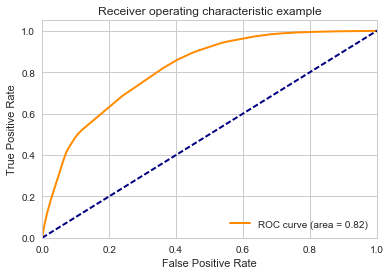

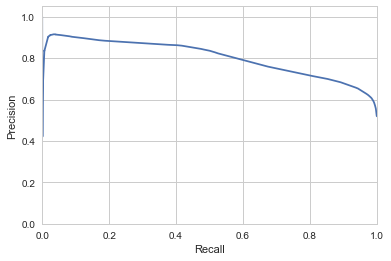

In [173]:
# Compute ROC curve and ROC area for each class. Any curve above the blue line 
# means that the algorithm is predicting better than by random chance. 
# However, we would ideally like to have the orange curve as close as possible to 
# the y-axis and ROC curve area to be in the .90's.

fpr, tpr, _ = metrics.roc_curve(y_test, y_score[:,1])
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
    
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_score[:,1])
plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

We can now take a quick glance at the errors and if there is anything else we could have done better in hindsight. The code below selects all records where the algorithm awas wrond on the test set. What insights can you make from that? (hint: use the same feature visualization techniques we used when selecting features). Note that we should do this with the dev set. Thus we quickly test on it before visualizing this. Ideally we would use a classifier also trained no the dev set, instead of best_clf. This is left as an exercise to the reader.

In [174]:
select_dev = dev[select_features + ['SEX']]
X_test = select_dev.ix[:, select_dev.columns != 'SEX'].values
y_test = le.fit_transform(select_dev['SEX'].values)
y_pred = best_clf.predict(X_test)
y_score = best_clf.predict_proba(X_test)

dev_wrong = dev[y_pred != y_test]

For example, the example below shows the distribution of different values of marriage feature .

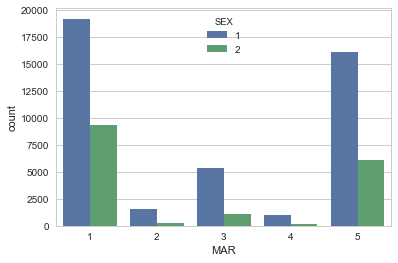

In [175]:
sns.countplot(data=dev_wrong, x='MAR', hue='SEX')

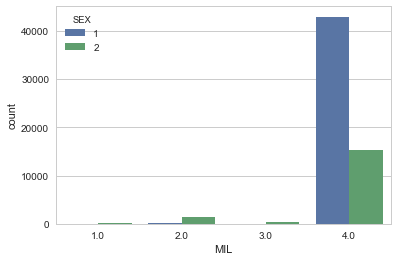

In [176]:
sns.countplot(data=dev_wrong, x='MIL', hue='SEX')

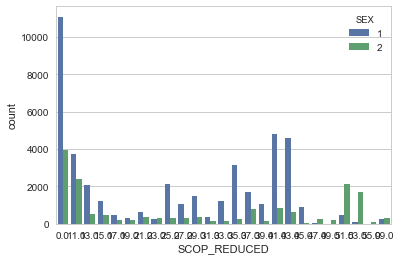

In [178]:
sns.countplot(data=dev_wrong, x='SCOP_REDUCED', hue='SEX')

In [181]:
import pydotplus
dot_data = export_graphviz(clf,
                           out_file=None,
                           feature_names=X_dev_long.columns,
                           class_names=['male', 'female'],  
                           filled=True, rounded=True,  
                           special_characters=True)  
# ran correctly for me when I first installed anaconda, but not now
# if you have trouble, just comment these two lines out and use the print line below instead.
#graph = pydotplus.graph_from_dot_data(dot_data)  
#Image(graph.create_png()) 

print(dot_data)

digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname=helvetica] ;
edge [fontname=helvetica] ;
0 [label=<MIL_4.0 &le; 0.5<br/>gini = 0.4994<br/>samples = 224156<br/>value = [108334, 115822]<br/>class = female>, fillcolor="#399de510"] ;
1 [label=<SCOP_REDUCED_43.0 &le; 0.5<br/>gini = 0.1515<br/>samples = 23415<br/>value = [21481, 1934]<br/>class = male>, fillcolor="#e58139e8"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label=<SCOP_REDUCED_29.0 &le; 0.5<br/>gini = 0.1363<br/>samples = 22196<br/>value = [20563, 1633]<br/>class = male>, fillcolor="#e58139eb"] ;
1 -> 2 ;
3 [label=<gini = 0.1258<br/>samples = 21628<br/>value = [20169, 1459]<br/>class = male>, fillcolor="#e58139ed"] ;
2 -> 3 ;
4 [label=<gini = 0.425<br/>samples = 568<br/>value = [394, 174]<br/>class = male>, fillcolor="#e581398e"] ;
2 -> 4 ;
5 [label=<MAR_1 &le; 0.5<br/>gini = 0.3719<br/>samples = 1219<br/>value = [918, 301]<br/>class = male>, fillcolor="#e58139ab"] ;
1 -> 5 

### Handin: (<strong>Both streams:</strong>)

## Summarize your findings about different features you selected, including insights about why they should help you predict/classify males and females.
- What features or combination of features do you think are predictive? You can use a chart illustrating why.

Individual features and combinations of features are visualized in the "Feature Selection" section of the notebook, so the reader is kindly requested to look at that section of the notebook.

To summarized about useful features for classifying males and females based on the development dataset:

I decided to include the following features

<em>Marital Status</em>: This feature is useful because of the category corresponding to the 'widowed' status - more females tend to be in this category because they tend to live longer.

<em>Military Service</em>: Fewer women than men serve in the military due to both political measures and social expectations. We see a strong difference in the involvement of these groups.

<em>Educational Attainment and Occupation</em>: We see some differences in the level of education and the different occupations that the sexes tend to get. These are particularly illustrative when considered in combination with the income.

<em>Personal Income, Wage, and Age</em>: While these do show some differences, they are most useful when considered in conjunction with some of the previously stated features. For example, looking at specific wage gaps within an occupation or for a different level of educational attainment might be useful to the classifier.

- What external knowledge did you use about differences between men and women (if any) to find these features? 

I used external knowledge about equity in military and in education to inform the features I thought might be distributed differently in men and women. One interesting insight I had as I was completing this analysis was the fact that these might depend significantly on the age of the participant. Because education, military, and income equity are topics that have been receiving increasing attention over time, the trends that are present for older generations may shift for younger generations. One such example is education: thirty years ago, about 60% of higher education degrees were granted to men, but today that statistic has reversed; 60% of higher education degrees are granted to females. So while I only investigated the impact of these features in total over the dataset (since they did show differences in distribution), it might be illustrative to consider how these change with age.

## Summarize your findings about the best performing algorithm/feature set in the development stage.
- State the scores (e.g., accuracy) of different algorithms/feature sets you compared.

For the best performing classifier I created, including the features that I have mentioned, I compared performance using the ZeroR, Naive Bayes, and Decision Tree Classifier. The performance of the algrithms in the development stage was the following:

In [179]:
scores[['algorithm', 'accuracy', 'precision', 'recall']].groupby(['algorithm']).median()

,accuracy,precision,recall
algorithm,,,
Decision Tree,0.732914,0.740294,0.742785
Naive Bayes,0.665232,0.672927,0.684290
ZeroR,0.516071,0.516071,1.000000


- What do the results of the statistical tests mean?

The results of the statistical tests tell us that we can reject the null hypothesis that the different classifiers are performing the same. Comparing pairs of classifiers, we see p-values that are less than (what number). This number means that with (what number) confidence, we know that the difference in the accuracy is a result of an actual difference in the classifiers and not just due to random error.

- What can we conclude from the analysis?

A more thorough discussion is included earlier in the notebook, so the reader is kindly requested to refer to these conclusions. As a summary:

The decision tree is the best algorithm for making predictions about the sex based on this decision tree. Since ZeroR just predicts the majority case, this is a good thing: the features we are including show that there is some ability to predict this rather than (basically) random chance. The decision tree is likely better than Naive Bayes because Naive Bayes assumes independence with respect to the class. For example, it assumes that the distribution of sexes in each occupation should be independent of the class, when we know that people can self-select into jobs and certain roles do tend to have more women. This assumption might be limiting its performance.

## Discuss the performance of the best algorithm (even if it is the one provided in the assignment).
- What was the best classifier you were able to create?

The best classifier I was able to create was a decision tree with approximately 73% accuracy. This is certainly not wonderful, showing an improvement of only ~2% over the baseline classifier provided in the assignment. However, comparing this to ZeroR, this is some improvement. ZeroR has ~51% accuracy, so it is basically assigning by random chance because the two classes are equally distributed in this dataset. The choice of a better algorithm as well as a more descriptive feature space are able to improve about half of the errors this baseline classifier. So while there is a ways to go, this does show good improvement!

- What features did you create or modify?

I added the military service and educational attainment features from the dataset, and included some binning for these features as well as the age feature in the hopes that looking at smaller subsets of the data might help the algorithm make more informed decisions about how the differences in the sexes are more prominent in particular bins.

- What were the accuracy, precision and recall of the result on your test set?

The accuracy of the test set was 74%, the precision 74% and the recall also 73%. This shows that the inclusion of these additional features had the greatest impact on the recall of my classifier. Nikola's baseline model had a recall of about 69%, so the inclusion of these additional features makes false negatives less likely.

- Is the best algorithm/feature set making reasonable decisions? (e.g., include a picture of the decision tree and talk about what you learned from it)

I discuss this point earlier in the notebook, so the reader is kindly asked to refer to this full discussion. Looking at the decision tree, we can see that it first splits on military service, then splits into a couple of occupations with very different male and female distributions, and finally splits based on income. This occupation split before the occupation split seems like a very important and reasonable decision, because a particular occupation is going to guide an income gap more than sex, so splitting on that first allows an equal comparison of different sexes. 

- What kind of errors is the best algorithm/feature set making and can we improve somehow?

The types of errors the algorithm seems to be making is in overconfidence with certain features. For example, I looked at the distribution of wrong assignments for the feature of military service. Because the category of "non-military" is predominantly female, the classifier is very likely to attribute non-military service to this category. Looking at the errors, we can see that most of the errors are the classification of men in that category: the algorithm is really good at predicting that a woman has likely not served in the military, but not great at knowing the correlary - that if somebody has not served in the military, they might not be a woman.

I think the problem is due in part to highly skewed features. The majority of the data in the military has not served; while the differences are very apparent, most people will not have served, so using that as a main differentiator as the algorithm is going to result in some difficulty in classifying the minority class.

One potential way this could be improved is to normalize these features: it would make the huge gap between the count of people who have and have not served seem a little less apparent.